### **Transfer Learning**

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

2025-07-19 21:17:54.178773: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-19 21:17:54.189160: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 21:17:54.284680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-19 21:17:54.354513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752977874.512932    9173 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752977874.53

In [3]:
# Create train_ds
data_dir = 'agri_crops/Agricultural-crops'
image_size = (224, 224)
batch_size = 10

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

#Create validation_ds
validation_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

# Define augmentation as a Sequential layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.02),
], name="data_augmentation")

# Extract class names
class_names = train_ds.class_names

# Apply data augmentation to the training set
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 759 files belonging to 30 classes.
Using 608 files for training.
Found 759 files belonging to 30 classes.
Using 151 files for validation.


2025-07-19 21:18:12.287001: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### **ResNet50V2**

In [4]:
def make_resnet_model(input_shape, num_classes):
    backbone = keras.applications.ResNet50V2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    backbone.trainable = False  # Frozen during initial training

    inputs = keras.Input(shape=input_shape)
    x = keras.applications.resnet_v2.preprocess_input(inputs)
    x = backbone(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="resnet50v2_model")

In [5]:
model_rn50_v2 = make_resnet_model(input_shape=(224, 224, 3), num_classes=30)

model_rn50_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("resnet50v2_baseline_best.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history_rn50_v2 = model_rn50_v2.fit(
    train_ds,
    epochs=60,
    validation_data=validation_ds,
    callbacks=callbacks,
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 55s 819ms/step - acc: 0.0583 - loss: 4.1173 - val_acc: 0.2980 - val_loss: 2.7497 - learning_rate: 3.0000e-04
Epoch 2/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 742ms/step - acc: 0.2034 - loss: 3.0235 - val_acc: 0.4834 - val_loss: 2.1350 - learning_rate: 3.0000e-04
Epoch 3/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 44s 709ms/step - acc: 0.3273 - loss: 2.3190 - val_acc: 0.5563 - val_loss: 1.7691 - learning_rate: 3.0000e-04
Epoch 4/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 752ms/step - acc: 0.4213 - loss: 2.0891 - val_acc: 0.5762 - val_loss: 1.6252 - learning_rate: 3.0000e-04
Epoch 5/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 46s 743ms/step - acc: 0.4684 - loss: 1.9262 - val_acc: 0.5960 - val_loss: 1.4852 - learning_rate: 3.0000e-04
Epoch 6/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 769ms/step - acc: 0.5266 - loss: 1.6992 - val_acc: 0.6159 - val_loss: 1.4625 - learning_rate: 3.0000e-04
Epoch 7/60
61/61 ━━━━━━━━━━━━━━━━━━━━ 48s 767ms/step - acc: 0.5039 

### **Train vs Validation Plot**

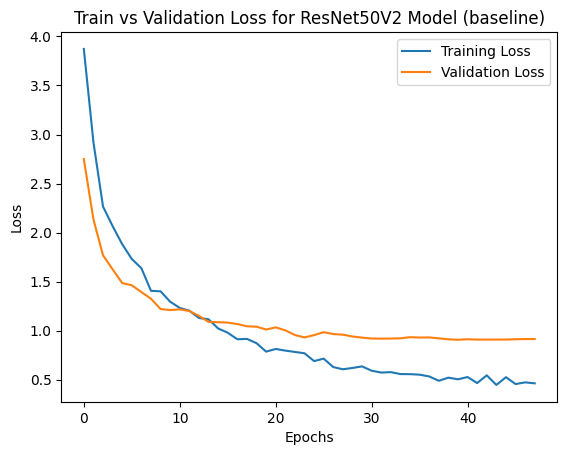

In [6]:
plt.plot(range(len(history_rn50_v2.history["loss"])), history_rn50_v2.history["loss"], label="Training Loss")
plt.plot(range(len(history_rn50_v2.history["val_loss"])), history_rn50_v2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss for ResNet50V2 Model (baseline)")
plt.legend()
plt.show()

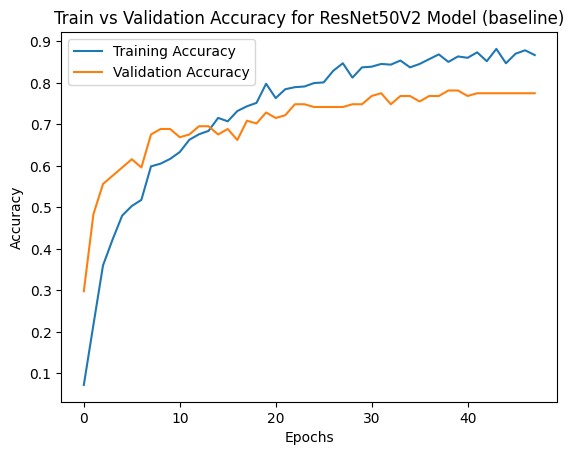

In [7]:
plt.plot(range(len(history_rn50_v2.history["acc"])), history_rn50_v2.history["acc"], label="Training Accuracy")
plt.plot(range(len(history_rn50_v2.history["val_acc"])), history_rn50_v2.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy for ResNet50V2 Model (baseline)")
plt.legend()
plt.show()

### **Classification Report**

In [8]:
# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for batch_images, batch_labels in validation_ds:
    preds = model_rn50_v2.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
                     precision    recall  f1-score   support

             Cherry       0.57      0.57      0.57         7
       Coffee-plant       1.00      0.57      0.73         7
           Cucumber       0.67      0.67      0.67         6
   Fox_nut(Makhana)       1.00      0.86      0.92         7
              Lemon       0.67      0.80      0.73         5
         Oli

2025-07-19 21:55:43.216281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/landao/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U